Adapted from https://github.com/hannahg141/ClimateNet/blob/main/data/feature_engineering.ipynb

# Setting up dependencies

In [2]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import glob
import os

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from pathlib import Path

!python --version

path = "climatenet_engineered/train/"
os.makedirs(path, exist_ok=True)

Python 3.13.11


# Exploring potential data augmentation

From the existing 16 channels, we aim to compute the following engineered features:

* **WS850**: wind speed at 850 hPa level
* **WSBOT**: wind speed at surface
* **RV850**: relative vorticity  at 850 hPa level
* **RVBOT**: relative vorticity at surface level

**Wind speed** is the L2 norm of the zonal + meridional components of the wind vector field:

$w_s = \sqrt{u^2 + v^2}$

**Wind vorticity** is the curl of the wind vector field around the w axis (λ = latitude, ϕ = longitude):

$\zeta = \frac{\partial u}{\partial λ} - \frac{1}{\textrm{cos} \phi} \frac{\partial v \textrm{cos} \theta}{\partial \phi}  $  




In [3]:
ds = xr.open_dataset('climatenet/train/data-2004-08-19-01-1_0.nc') # loading one data sample

In [4]:
ds

<xarray.Dataset> Size: 64MB
Dimensions:  (time: 1, lat: 768, lon: 1152)
Coordinates:
  * time     (time) <U23 92B 'data-2004-08-19-01-1.nc'
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 4MB ...
    U850     (time, lat, lon) float32 4MB ...
    V850     (time, lat, lon) float32 4MB ...
    UBOT     (time, lat, lon) float32 4MB ...
    VBOT     (time, lat, lon) float32 4MB ...
    QREFHT   (time, lat, lon) float32 4MB ...
    ...       ...
    TS       (time, lat, lon) float32 4MB ...
    TREFHT   (time, lat, lon) float32 4MB ...
    Z1000    (time, lat, lon) float32 4MB ...
    Z200     (time, lat, lon) float32 4MB ...
    ZBOT     (time, lat, lon) float32 4MB ...
    LABELS   (lat, lon) int64 7MB ...

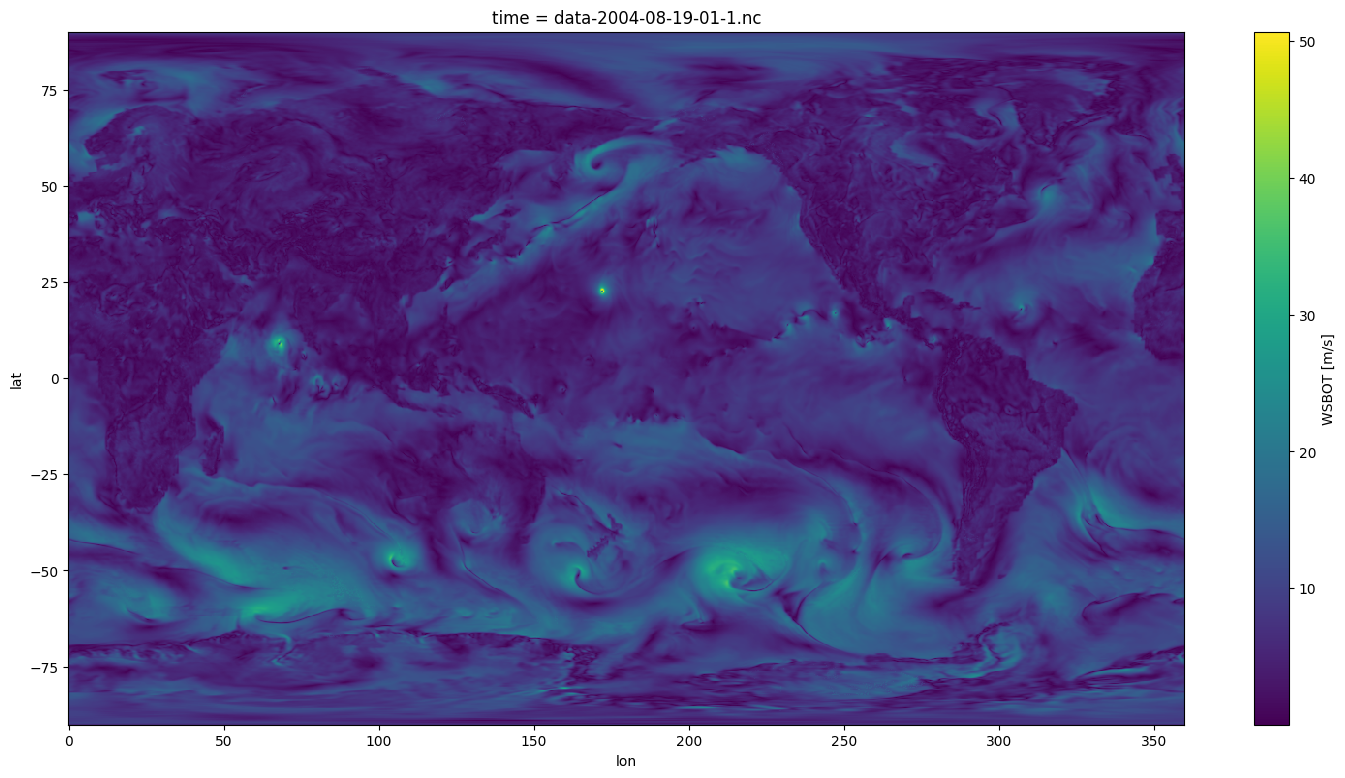

In [5]:
ubot = ds["UBOT"]
vbot = ds["VBOT"]
ds["WSBOT"] = np.sqrt(ubot**2 + vbot**2)
ds.WSBOT.attrs['description'] = 'wind speed at lowest level'
ds.WSBOT.attrs['units'] = 'm/s'

fig = plt.figure(figsize=(18,9))
ds.WSBOT[0,:,:].plot()

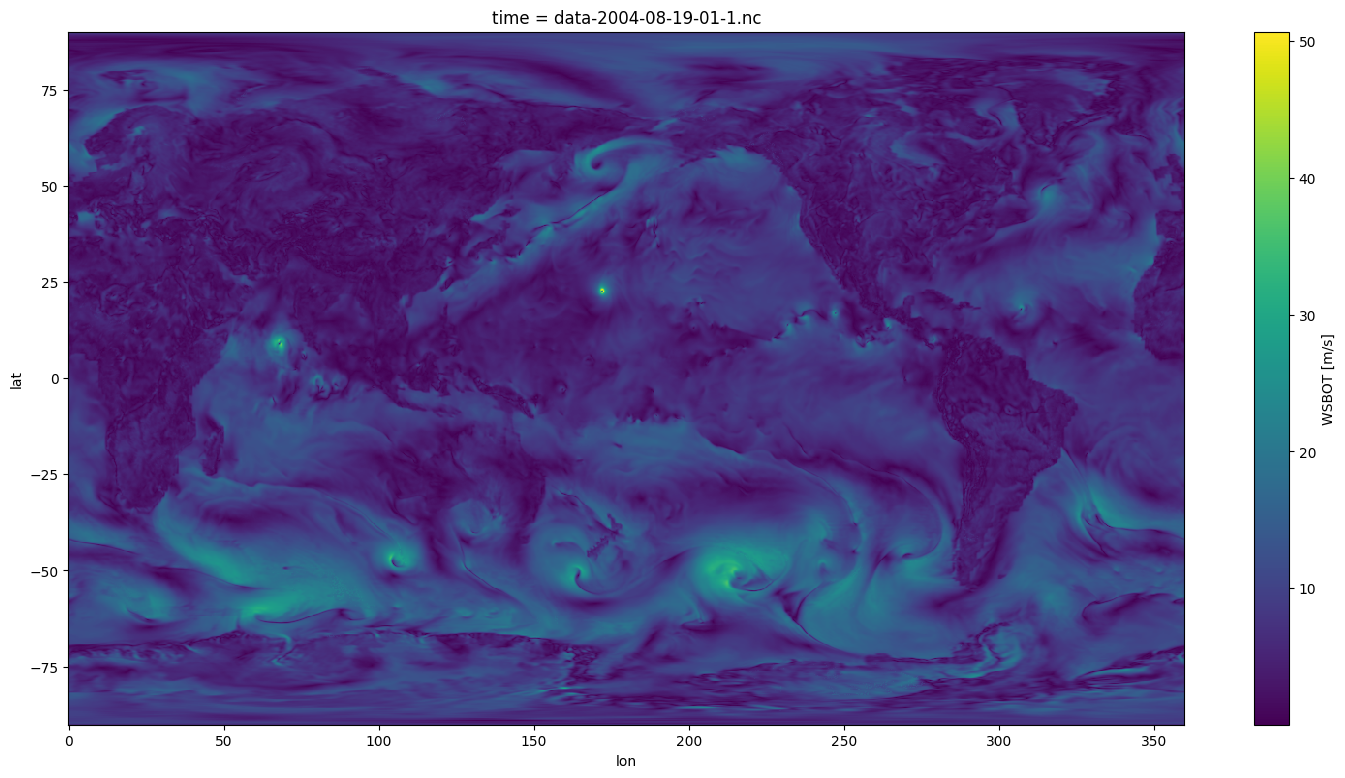

In [6]:
u850 = ds.U850
v850 = ds.U850
ds["WS850"] = np.sqrt(u850**2 + v850**2)
ds.WS850.attrs['description'] = 'wind speed at 850 hPa'
ds.WS850.attrs['units'] = 'm/s'

fig = plt.figure(figsize=(18,9))
ds.WSBOT[0,:,:].plot()

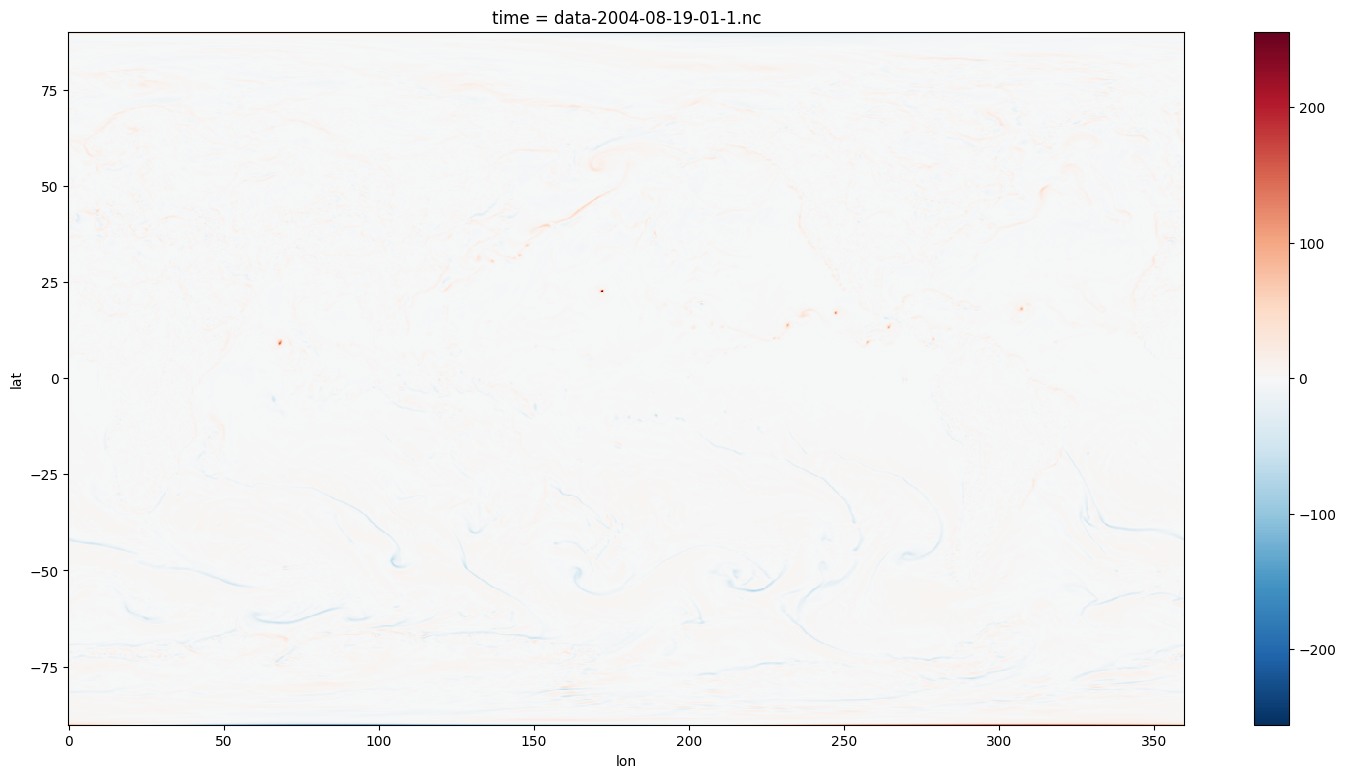

In [7]:
lat = ds["lat"]
lon = ds["lon"]
u = ds.UBOT[0,:,:]
v = ds.VBOT[0,:,:]

dv = v.differentiate("lon")

cosT = np.cos(lat*(np.pi/180))
u_cosT = u * cosT
du = (1/(1e-3+cosT)) * u_cosT.differentiate("lat")

vorticity_bottom = dv.astype(np.float32) - du.astype(np.float32)

ds["VORTBOT"] = vorticity_bottom
ds.VORTBOT.attrs['description'] = 'wind vorticity at lowest level'
ds.VORTBOT.attrs['units'] = 's^-1'

fig = plt.figure(figsize=(18,9))
p = vorticity_bottom.plot()

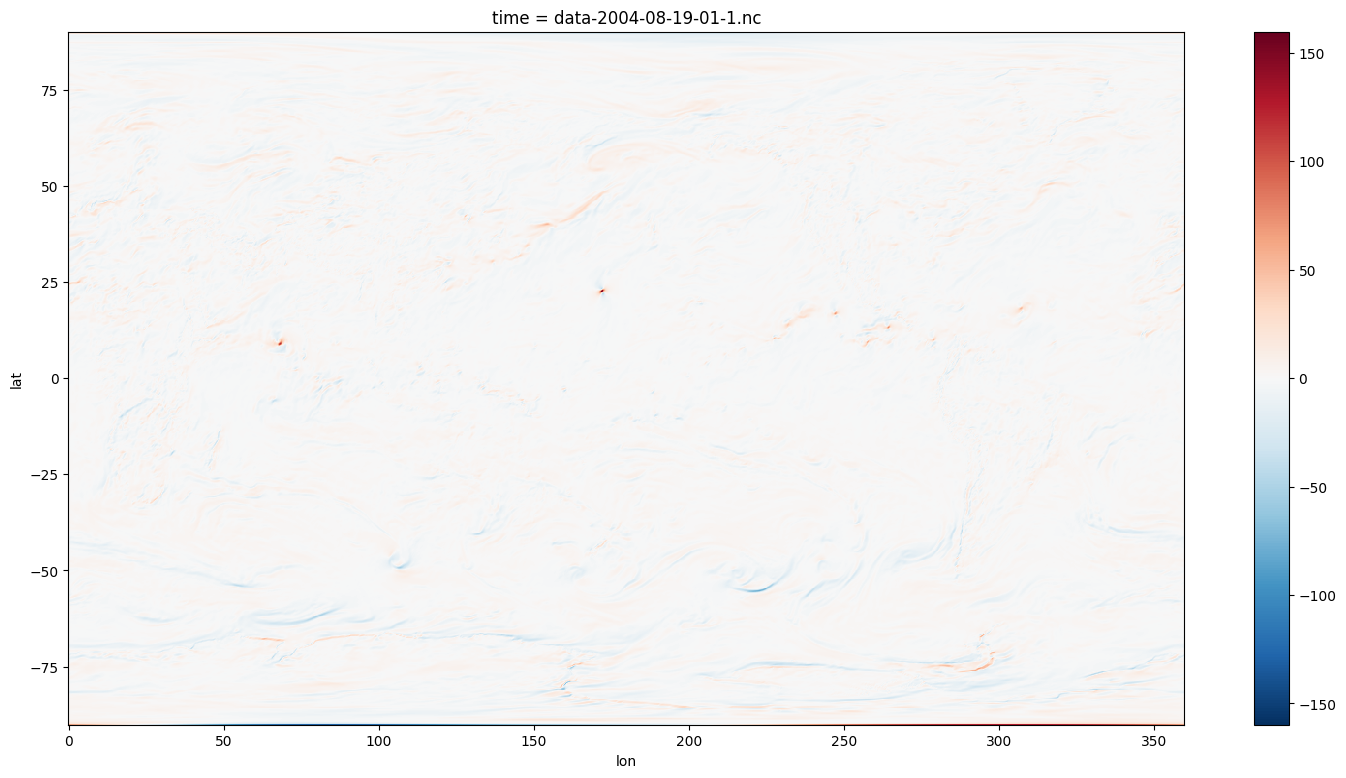

In [8]:
lat = ds["lat"]
lon = ds["lon"]
u = u850[0,:,:]
v = v850[0,:,:]

dv = v.differentiate("lon")

cosT = np.cos(lat*(np.pi/180))
u_cosT = u * cosT
du = (1/(1e-3+cosT)) * u_cosT.differentiate("lat")

vorticity850 = dv - du

ds["VORT850"] = vorticity850.astype(np.float32)
ds.VORT850.attrs['description'] = 'wind vorticity at 850 hPa'
ds.VORT850.attrs['units'] = 's^-1'

fig = plt.figure(figsize=(18,9))
p = vorticity850.plot()




# Generate new channels

We iterate through the train and test sets.

From the existing 16 channels, we aim to compute the following engineered features:

* WS850: wind speed at 850 hPa level
* WSBOT: wind speed at surface
* RV850: relative vorticity at 850 hPa level
* RVBOT: relative vorticity at surface level

We then keep only the following initial channels:
* U/VBOT
* U/V850
* PS
* TMQ
* PRECT

We then save the new sample to our Engineered data set.


In [9]:
def velocity(u, v):

    wind_speed = np.sqrt(u**2 + v**2)
    return wind_speed


def vorticity(u, v):

    dv = v.differentiate("lon")
    cosTheta = np.cos(lat*(np.pi/180))
    
    u_cosTheta = u * cosTheta
    du = (1/(1e-3+cosTheta)) * u_cosTheta.differentiate("lat")

    zeta = dv - du
    return zeta.astype(np.float32)


In [ ]:
origin_folder = 'climatenet/test/' 
dest_folder = 'climatenet_engineered/test/'

for idx, filename_in in enumerate(glob.glob(origin_folder + '*.nc')):

    ds = xr.open_dataset(filename_in)

    file = Path(filename_in)
    print(str(idx)+". Processing: "+file.stem+file.suffix)

    lat = ds["lat"]
    lon = ds["lon"]

    # Wind speed at 850 hPa
    ds["WS850"] = velocity(ds.U850, ds.V850)
    ds.WS850.attrs['description'] = 'wind speed at 850 mbar pressure surface'
    ds.WS850.attrs['units'] = 'm/s'

    # Wind speed at lower level
    ds["WSBOT"] = velocity(ds.UBOT, ds.VBOT)
    ds.WSBOT.attrs['description'] = 'lowest level wind speed'
    ds.WSBOT.attrs['units'] = 'm/s'

    # Wind vorticity at 850 hPa
    ds["VRT850"] = vorticity(ds.U850[0,:,:], ds.V850[0,:,:]).astype(np.float32)
    ds.VRT850.attrs['description'] = 'wind vorticity at 850 mbar pressure surface'
    ds.VRT850.attrs['units'] = 's^-1'

    # Wind vorticity at 850 hPa
    ds["VRTBOT"] = vorticity(ds.UBOT[0,:,:], ds.VBOT[0,:,:]).astype(np.float32)
    ds.VRTBOT.attrs['description'] = 'lowest level wind vorticity'
    ds.VRTBOT.attrs['units'] = 's^-1'
    # Clean up sample
    # ds = ds.drop_vars(['TREFHT', 'PS', 'QREFHT', 'T200', 'T500', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT']) 
    # Save sample to new folder
    filename_out = dest_folder + file.stem + file.suffix
    print("Saving: "+filename_out+'\n')

    ds.to_netcdf(filename_out)
    

0. Processing: data-2013-07-03-01-1_1.nc
Saving: climatenet_engineered/test/data-2013-07-03-01-1_1.nc

1. Processing: data-2011-09-09-01-1_1.nc
Saving: climatenet_engineered/test/data-2011-09-09-01-1_1.nc

2. Processing: data-2013-08-13-01-1_0.nc
Saving: climatenet_engineered/test/data-2013-08-13-01-1_0.nc

3. Processing: data-2012-10-18-01-1_1.nc
Saving: climatenet_engineered/test/data-2012-10-18-01-1_1.nc

4. Processing: data-2013-08-01-01-1_1.nc
Saving: climatenet_engineered/test/data-2013-08-01-01-1_1.nc

5. Processing: data-2013-08-20-01-1_1.nc
Saving: climatenet_engineered/test/data-2013-08-20-01-1_1.nc

6. Processing: data-2013-06-27-01-1_2.nc
Saving: climatenet_engineered/test/data-2013-06-27-01-1_2.nc

7. Processing: data-2012-10-18-01-1_0.nc
Saving: climatenet_engineered/test/data-2012-10-18-01-1_0.nc

8. Processing: data-2013-08-01-01-1_0.nc
Saving: climatenet_engineered/test/data-2013-08-01-01-1_0.nc

9. Processing: data-2013-08-20-01-1_0.nc
Saving: climatenet_engineered/te

In [20]:
ds

<xarray.Dataset> Size: 78MB
Dimensions:  (time: 1, lat: 768, lon: 1152)
Coordinates:
  * time     (time) <U23 92B 'data-2012-08-17-01-1.nc'
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Data variables: (12/21)
    TMQ      (time, lat, lon) float32 4MB ...
    U850     (time, lat, lon) float32 4MB -0.03533 -0.009455 ... 10.02 10.0
    V850     (time, lat, lon) float32 4MB -4.743 -4.744 -4.744 ... -2.579 -2.634
    UBOT     (time, lat, lon) float32 4MB -0.03533 -0.009455 ... 9.781 9.795
    VBOT     (time, lat, lon) float32 4MB -4.743 -4.744 -4.744 ... 1.833 1.78
    QREFHT   (time, lat, lon) float32 4MB ...
    ...       ...
    ZBOT     (time, lat, lon) float32 4MB ...
    LABELS   (lat, lon) int64 7MB ...
    WS850    (time, lat, lon) float32 4MB 4.744 4.744 4.744 ... 10.34 10.34
    WSBOT    (time, lat, lon) float32 4MB 4.744 4.744 4.744 ... 9.951 9.955
    VRT850   (lat, lon) float32 4MB 31.96 31.38 30.8 30.22 ... 184.9 184.7 184.4
    VRTBOT   (lat, lon) float32 4MB 31.96 31.38 30.8 30.22 ... 172.8 172.9 173.1

# Computing statistics 

Training our model requires a normalizing step that we pre-process to improve training speed. Here we compute `mean` and `std` for all channels.  

In [12]:
from math import pi
import pandas as pd

folder = 'climatenet_engineered/train/'
channels = ["TMQ", "U850", "V850", "UBOT", "VBOT", "PSL", "PRECT", "WS850", "WSBOT", "VRT850", "VRTBOT"]
pixels = ["LABELS:BG", "LABELS:TC", "LABELS:AR"]

col_names = []
for channel in channels:
  col_names += [channel+" Mean", channel+" Std Dev"]
col_names += pixels

rows = [] 

In [13]:
for idx, filename in enumerate(glob.glob(folder + '*.nc')):

    ds = xr.open_dataset(filename)

    file = Path(filename)
    if idx%10 == 0:
      print(str(idx)+". Processing: "+file.stem+file.suffix)

    new_row = []

    for channel in channels:
     new_row = new_row + [ds[channel].mean().values.item(), ds[channel].std().values.item()]

    labels = ds.LABELS
    new_row += [labels.where(labels==0).count().values.item(),\
              labels.where(labels==1).count().values.item(),\
              labels.where(labels==2).count().values.item()]

    rows.append(new_row)

    ds.close()

df = pd.DataFrame(rows, columns = col_names)
df

0. Processing: data-2009-10-09-01-1_0.nc
10. Processing: data-2000-04-17-01-1_4.nc
20. Processing: data-1999-06-21-01-1_1.nc
30. Processing: data-2004-08-14-01-1_0.nc
40. Processing: data-2000-09-09-01-1_0.nc
50. Processing: data-2004-07-04-01-1_1.nc
60. Processing: data-2001-12-18-01-1_0.nc
70. Processing: data-2001-07-18-01-1_0.nc
80. Processing: data-1997-08-14-01-1_2.nc
90. Processing: data-2007-10-06-01-1_2.nc
100. Processing: data-2001-12-07-01-1_5.nc
110. Processing: data-2001-08-04-01-1_0.nc
120. Processing: data-2004-06-24-01-1_0.nc
130. Processing: data-2009-06-27-01-1_0.nc
140. Processing: data-2003-07-24-01-1_0.nc
150. Processing: data-2002-03-31-01-1_2.nc
160. Processing: data-1998-08-23-01-1_0.nc
170. Processing: data-2000-12-20-01-1_1.nc
180. Processing: data-2001-07-12-01-1_5.nc
190. Processing: data-1998-08-31-01-1_1.nc
200. Processing: data-1996-07-18-01-1_2.nc
210. Processing: data-2004-10-24-01-1_0.nc
220. Processing: data-2002-08-24-01-1_1.nc
230. Processing: data-

,TMQ Mean,TMQ Std Dev,U850 Mean,U850 Std Dev,V850 Mean,V850 Std Dev,UBOT Mean,UBOT Std Dev,VBOT Mean,VBOT Std Dev,...,WS850 Std Dev,WSBOT Mean,WSBOT Std Dev,VRT850 Mean,VRT850 Std Dev,VRTBOT Mean,VRTBOT Std Dev,LABELS:BG,LABELS:TC,LABELS:AR
0,18.403793,15.823866,2.043010,8.794699,0.205480,6.735053,0.474373,7.180959,0.370465,6.228402,...,6.513214,8.015202,5.145676,0.121231,9.335754,0.043425,7.585462,809481,2137,73118
1,20.198147,15.943586,2.003802,8.010127,0.384370,5.712602,0.447590,6.353288,0.600213,5.682329,...,5.618612,7.218340,4.594484,0.014902,6.004806,0.013582,5.572271,773437,8835,102464
2,20.129490,15.621581,1.783659,7.726275,0.369962,5.692836,0.236262,6.158954,0.357512,5.476635,...,5.546723,6.999972,4.371531,-0.012786,5.465820,-0.023170,5.187106,817865,2317,64554
3,20.773121,15.558476,1.635945,8.189574,0.452403,6.260236,0.202479,6.609315,0.268887,5.793180,...,5.811048,7.505300,4.585602,-0.074846,6.568268,-0.058692,6.434571,838600,9283,36853
4,18.560328,15.848878,1.760258,7.719549,0.216098,6.298831,0.338486,6.270225,0.443228,5.862597,...,5.622038,7.281845,4.579468,0.020083,5.764015,0.027254,5.968631,824714,10323,49699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,20.366451,15.581383,0.711370,7.942636,0.405222,5.592536,-0.460837,6.505243,0.612876,5.375153,...,5.256059,7.285534,4.326597,-0.073116,5.878646,-0.053670,5.570875,836882,3038,44816
394,16.882217,15.774350,1.052116,8.375102,-0.116818,6.370841,-0.024709,6.641102,-0.145967,5.641215,...,6.076690,7.298072,4.763151,0.006062,6.734067,0.008449,5.988194,883635,1101,0
395,20.655966,15.835803,1.153438,8.321647,0.457770,5.854714,-0.091424,6.499770,0.434850,5.576983,...,5.606803,7.364599,4.394300,-0.029667,5.445817,-0.057060,4.569070,813383,5678,65675
396,20.442904,15.738139,1.523643,8.095950,0.343403,6.751126,0.093272,6.554275,0.526449,6.100545,...,6.132286,7.514852,4.897757,-0.017008,6.237813,-0.015543,5.665750,858972,1203,24561


In [14]:
df

,TMQ Mean,TMQ Std Dev,U850 Mean,U850 Std Dev,V850 Mean,V850 Std Dev,UBOT Mean,UBOT Std Dev,VBOT Mean,VBOT Std Dev,...,WS850 Std Dev,WSBOT Mean,WSBOT Std Dev,VRT850 Mean,VRT850 Std Dev,VRTBOT Mean,VRTBOT Std Dev,LABELS:BG,LABELS:TC,LABELS:AR
0,18.403793,15.823866,2.043010,8.794699,0.205480,6.735053,0.474373,7.180959,0.370465,6.228402,...,6.513214,8.015202,5.145676,0.121231,9.335754,0.043425,7.585462,809481,2137,73118
1,20.198147,15.943586,2.003802,8.010127,0.384370,5.712602,0.447590,6.353288,0.600213,5.682329,...,5.618612,7.218340,4.594484,0.014902,6.004806,0.013582,5.572271,773437,8835,102464
2,20.129490,15.621581,1.783659,7.726275,0.369962,5.692836,0.236262,6.158954,0.357512,5.476635,...,5.546723,6.999972,4.371531,-0.012786,5.465820,-0.023170,5.187106,817865,2317,64554
3,20.773121,15.558476,1.635945,8.189574,0.452403,6.260236,0.202479,6.609315,0.268887,5.793180,...,5.811048,7.505300,4.585602,-0.074846,6.568268,-0.058692,6.434571,838600,9283,36853
4,18.560328,15.848878,1.760258,7.719549,0.216098,6.298831,0.338486,6.270225,0.443228,5.862597,...,5.622038,7.281845,4.579468,0.020083,5.764015,0.027254,5.968631,824714,10323,49699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,20.366451,15.581383,0.711370,7.942636,0.405222,5.592536,-0.460837,6.505243,0.612876,5.375153,...,5.256059,7.285534,4.326597,-0.073116,5.878646,-0.053670,5.570875,836882,3038,44816
394,16.882217,15.774350,1.052116,8.375102,-0.116818,6.370841,-0.024709,6.641102,-0.145967,5.641215,...,6.076690,7.298072,4.763151,0.006062,6.734067,0.008449,5.988194,883635,1101,0
395,20.655966,15.835803,1.153438,8.321647,0.457770,5.854714,-0.091424,6.499770,0.434850,5.576983,...,5.606803,7.364599,4.394300,-0.029667,5.445817,-0.057060,4.569070,813383,5678,65675
396,20.442904,15.738139,1.523643,8.095950,0.343403,6.751126,0.093272,6.554275,0.526449,6.100545,...,6.132286,7.514852,4.897757,-0.017008,6.237813,-0.015543,5.665750,858972,1203,24561


Compute summary statistics:

In [15]:
from tabulate import tabulate

values = list(df.mean())

means = values[0:21:2]
stds = values[1:22:2]

table=list(zip(channels, means, stds))
print(tabulate(table, headers=['Channels', 'Mean', 'Std Dev'], tablefmt="presto"))

 Channels   |             Mean |        Std Dev
------------+------------------+----------------
 TMQ        |     19.2185      |   15.7346
 U850       |      1.55302     |    8.28026
 V850       |      0.254132    |    6.21792
 UBOT       |      0.124879    |    6.64294
 VBOT       |      0.315416    |    5.77158
 PSL        | 100814           | 1443.81
 PRECT      |      2.94582e-08 |    1.55088e-07
 WS850      |      8.70061     |    5.85448
 WSBOT      |      7.47795     |    4.672
 VRT850     |      0.00256632  |    6.85154
 VRTBOT     |     -0.00130753  |    6.11551


Channels   |             Mean |        Std Dev
------------|------------------|----------------
 TMQ        |     19.2185      |   15.7346
 U850       |      1.55302     |    8.28026
 V850       |      0.254132    |    6.21792
 UBOT       |      0.124879    |    6.64294
 VBOT       |      0.315416    |    5.77158
 PSL        | 100814           | 1443.81
 PRECT      |      2.94582e-08 |    1.55088e-07
 WS850      |      8.70061     |    5.85448
 WSBOT      |      7.47795     |    4.672
 VRT850     |      0.00256632  |    6.85154
 VRTBOT     |     -0.00130753  |    6.11551

In [16]:
from tabulate import tabulate

counts = list(df.mean())
counts = counts[22:25]
total = np.sum(counts)
BG = 100*counts[0]/total
TC = 100*counts[1]/total
AR = 100*counts[2]/total

print("Labels frequencies: ")
print('{:.3f}'.format(BG), '{:.3f}'.format(TC), '{:.3f}'.format(AR))
print("\n")
print("Ideal weights: ")
print('{:.3f}'.format(100/(3*BG)), '{:.3f}'.format(100/(3*TC)), '{:.3f}'.format(100/(3*AR)))

Labels frequencies: 
93.865 0.462 5.674


Ideal weights: 
0.355 72.171 5.875


Pixel classes       |   Background |   Tropical Cyclones |   Atmospheric Rivers
--------------------|--------------|---------------------|----------------------
Frequency           |   93.865 %   |   0.462 %           |   5.674 %    
Normalized weights  |   0.355      |   72.171            |   5.875